# Startups operations/close predictions

**Задача**

На входе имеются данные о стартапах, функционировавших в период с 1970 по 2018 годы. Необходимо разработать модель для предсказания успешности стартапа (закроется или нет).

Файлы:
1) kaggle_startups_train_28062024.csv - тренировочная выборка

2) kaggle_startups_test_28062024.csv - входные признаки тестовой выборки

Описание полей данных

name - Название стартапа

category_list - Список категорий, к которым относится стартап

funding_total_usd - Общая сумма финансирования в USD

status - Статус стартапа (закрыт или действующий)

country_code - Код страны

state_code - Код штата

region - Регион

city - Город

funding_rounds - Количество раундов финансирования

founded_at - Дата основания

first_funding_at - Дата первого раунда финансирования

last_funding_at - Дата последнего раунда финансирования

closed_at - Дата закрытия стартапа (если применимо)

lifetime - Время существования стартапа в днях

In [327]:
# !pip install scikit-learn
# !pip install shap
# !pip install phik
# !pip install imbalanced-learn 
# !pip install category_encoders
#!pip install -q feature_engine
#!pip install catboost

In [328]:
from datetime import date, datetime 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC
from catboost import CatBoostClassifier
import shap
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import ADASYN
from imblearn.base import FunctionSampler
from imblearn.pipeline import make_pipeline as make_imblearn_pipeline
from feature_engine.selection import DropCorrelatedFeatures, DropConstantFeatures

## Загрузка данных

In [329]:
train_dates_column_names = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
test_dates_column_names = ['first_funding_at', 'last_funding_at']

startups_train = pd.read_csv('./datasets/kaggle_startups_train_28062024.csv', parse_dates=train_dates_column_names)
startups_test = pd.read_csv('./datasets/kaggle_startups_test_28062024.csv', parse_dates=test_dates_column_names)

In [330]:
def tables_info():
    display(startups_train.head())
    display(startups_train.info())
    display(startups_test.head())
    display(startups_test.info())

In [331]:
tables_info()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaT
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaT
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaT
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaT
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaT


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

None

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               13125 non-null  object        
 1   category_list      12534 non-null  object        
 2   funding_total_usd  10547 non-null  float64       
 3   country_code       11743 non-null  object        
 4   state_code         11430 non-null  object        
 5   region             11536 non-null  object        
 6   city               11538 non-null  object        
 7   funding_rounds     13125 non-null  int64         
 8   first_funding_at   13125 non-null  datetime64[ns]
 9   last_funding_at    13125 non-null  datetime64[ns]
 10  lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(6)
memory usage: 1.1+ MB


None

При загрузке проблем не обнаружено. В некоторых столбцах есть пропуски, возможно, требующие обработки.

## Предобработка данных

In [332]:
startups_train[startups_train.duplicated()]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


In [333]:
startups_test[startups_test.duplicated()]

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


In [334]:
startups_train[startups_train.duplicated(subset=['name'])]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


In [335]:
startups_test[startups_test.duplicated(subset=['name'])]


,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime


In [336]:
list(startups_train['category_list'].unique())

['Online Reservations|Restaurants',
 'Manufacturing|Medical|Medical Devices',
 'Biotechnology',
 'Health Care',
 'Manufacturing',
 'Mobile',
 'Analytics|Business Analytics|Social CRM|Social Media Monitoring|Software',
 'Software',
 'Semiconductors',
 'Clean Technology',
 nan,
 'Nanotechnology|Technology|Wine And Spirits',
 'Customer Service|Delivery|Retail',
 'Analytics|Cloud Data Services|Computers|Networking|Software',
 'Banking|Finance|Loyalty Programs',
 'Messaging',
 'Consumers',
 'Generation Y-Z|Photo Sharing|Social Media',
 'College Recruiting|Enterprise Software|Recruiting|SaaS|Social Recruiting|Software',
 'Technology',
 'Finance|Financial Services|Payments',
 'Cloud Computing|Enterprise Resource Planning|Manufacturing|Software',
 'DIY|Environmental Innovation',
 'Entertainment|Games',
 'Internet|Pets|Services',
 'Advertising|Sales and Marketing',
 'Fitness|Sports',
 'Consumer Goods|Food Processing|Organic Food',
 'Analytics|Big Data|Business Intelligence|Marketplaces',
 'Mone

In [337]:
startups_train.isna().sum()

name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

In [338]:
startups_test.isna().sum()

name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
dtype: int64

Явных дубликатов не обнаружено. Стоит отметить, что в категориальных признаках таких как `category_list`, `country_code`, `region`, `city` много уникальных значений, которые сложно проанализировать на предмет неявных дублей. Также видно, что в категориях стартапов `category_list` есть перересекающиеся категории, например: `Manufacturing|Medical|Medical Devices` и `Manufacturing`.

В данных присутствует множество пропусков - решено не удалять данные с пропусками и заполнить их в pipeline на этапе обучения модели.

## Исследовательский анализ данных

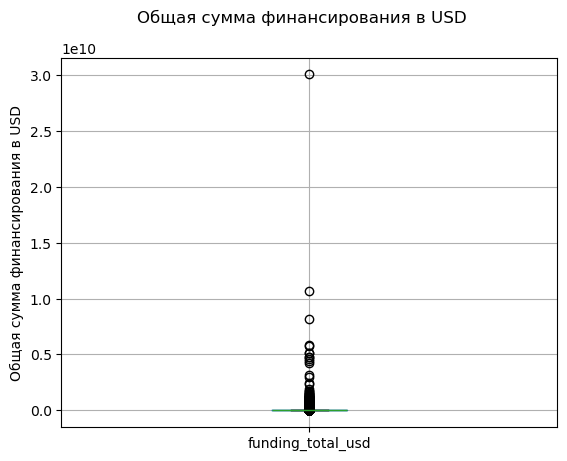

In [339]:
plt.suptitle('Общая сумма финансирования в USD')
funding_total_boxplot = startups_train.boxplot(column='funding_total_usd');
funding_total_boxplot.set_ylabel('Общая сумма финансирования в USD');

In [340]:
startups_train['funding_total_usd'].describe()

count    4.244700e+04
mean     1.824748e+07
std      1.871173e+08
min      1.000000e+00
25%      3.360275e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

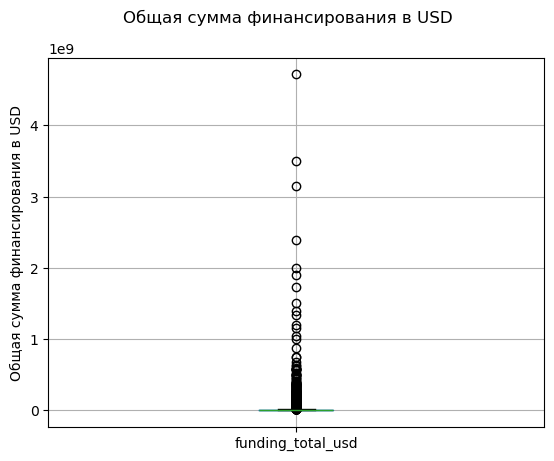

In [341]:
plt.suptitle('Общая сумма финансирования в USD')
funding_total_test_boxplot = startups_test.boxplot(column='funding_total_usd');
funding_total_test_boxplot.set_ylabel('Общая сумма финансирования в USD');

In [342]:
startups_test['funding_total_usd'].describe()

count    1.054700e+04
mean     1.654910e+07
std      9.217283e+07
min      1.000000e+00
25%      3.200000e+05
50%      2.000000e+06
75%      1.000000e+07
max      4.715000e+09
Name: funding_total_usd, dtype: float64

Финансирование стартапов имеет большой разброс по суммам инвестиций. Среднее значение в обучающей выборке ~ 18 млн, в тестовой - 16 млн. Интересно, что даже есть инвестиции размером в 1 доллар.

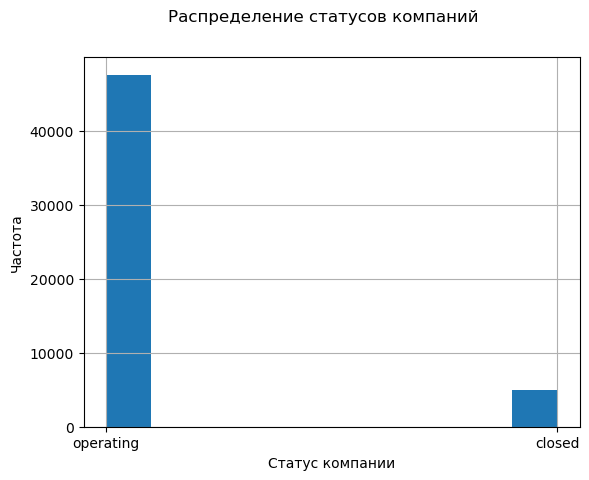

In [343]:
plt.suptitle('Распределение статусов компаний')
status_hist = startups_train['status'].hist();
status_hist.set_xlabel('Статус компании');
status_hist.set_ylabel('Частота');

По графику видно, что закрытых конпаний намного меньше (менее 10%). Следовательно нужно учесть, что при обучении возможена проблема дисбаланса классов.

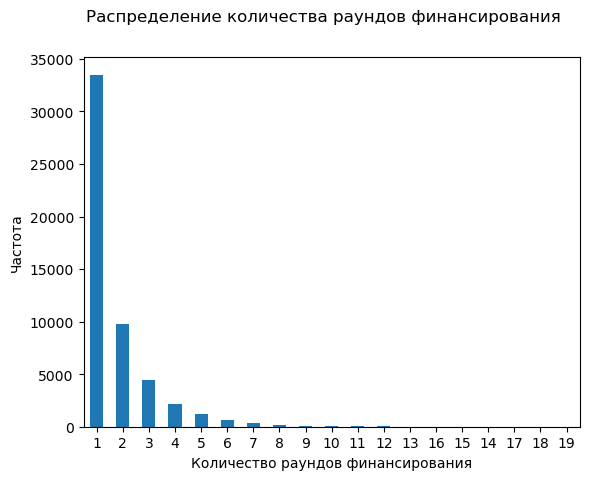

In [344]:
plt.suptitle('Распределение количества раундов финансирования')
funding_rounds_hist = startups_train['funding_rounds'].value_counts().plot(kind='bar', rot=0);
funding_rounds_hist.set_xlabel('Количество раундов финансирования');
funding_rounds_hist.set_ylabel('Частота');

In [345]:
startups_train['funding_rounds'].describe()

count    52516.000000
mean         1.740670
std          1.374522
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64

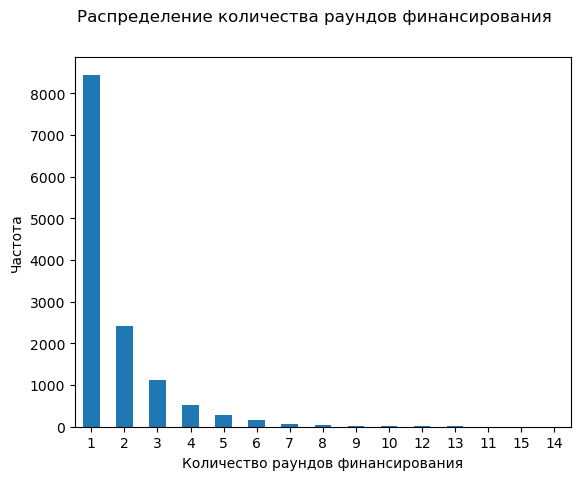

In [346]:
plt.suptitle('Распределение количества раундов финансирования')
funding_rounds_hist_test = startups_test['funding_rounds'].value_counts().plot(kind='bar', rot=0);
funding_rounds_hist_test.set_xlabel('Количество раундов финансирования');
funding_rounds_hist_test.set_ylabel('Частота');

In [347]:
startups_test['funding_rounds'].describe()

count    13125.000000
mean         1.714438
std          1.318800
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: funding_rounds, dtype: float64

В большистве случаев у компаний только один или два раунда финансирования. В среднем ~ 1.7 раундов. 

## Корреляционный анализ

In [348]:
# startups_train_cor = startups_train.copy()
# startups_test_cor = startups_test.copy()

# #Закодируем категориальные признаки. Используется LabelEncoder, т.к. в уникальных значений слишком много
# le_category_list = LabelEncoder()
# le_category_list.fit(pd.concat([startups_train_cor['category_list'], startups_test_cor['category_list']], ignore_index=True))
# le_labels = le_category_list.transform(startups_train_cor['category_list'])
# startups_train_cor['enc_category_list'] = le_labels

# le_labels = le_category_list.transform(startups_test_cor['category_list'])
# startups_test_cor['enc_category_list'] = le_labels

# le_country_code = LabelEncoder()
# le_country_code.fit(pd.concat([startups_train_cor['country_code'], startups_test_cor['country_code']], ignore_index=True))
# le_labels = le_country_code.transform(startups_train_cor['country_code'])
# startups_train_cor['enc_country_code'] = le_labels

# le_labels = le_country_code.transform(startups_test_cor['country_code'])
# startups_test_cor['enc_country_code'] = le_labels

# le_state_code = LabelEncoder()
# le_state_code.fit(pd.concat([startups_train_cor['state_code'], startups_test_cor['state_code']], ignore_index=True))
# le_labels = le_state_code.transform(startups_train_cor['state_code'])
# startups_train_cor['enc_state_code'] = le_labels

# le_labels = le_state_code.transform(startups_test_cor['state_code'])
# startups_test_cor['enc_state_code'] = le_labels

# le_region = LabelEncoder()
# le_region.fit(pd.concat([startups_train_cor['region'], startups_test_cor['region']], ignore_index=True))
# le_labels = le_region.transform(startups_train_cor['region'])
# startups_train_cor['enc_region'] = le_labels

# le_labels = le_region.transform(startups_test_cor['region'])
# startups_test_cor['enc_region'] = le_labels

# le_city = LabelEncoder()
# le_city.fit(pd.concat([startups_train_cor['city'], startups_test_cor['city']], ignore_index=True))
# le_labels = le_city.transform(startups_train_cor['city'])
# startups_train_cor['enc_city'] = le_labels

# le_labels = le_city.transform(startups_test_cor['city'])
# startups_test_cor['enc_city'] = le_labels

# le_founded_at = LabelEncoder()
# le_founded_at.fit(startups_train_cor['founded_at'])
# le_labels = le_founded_at.transform(startups_train_cor['founded_at'])
# startups_train_cor['enc_founded_at'] = le_labels

# le_first_funding_at = LabelEncoder()
# le_first_funding_at.fit(pd.concat([startups_train_cor['first_funding_at'], startups_test_cor['first_funding_at']], ignore_index=True))
# le_labels = le_first_funding_at.transform(startups_train_cor['first_funding_at'])
# startups_train_cor['enc_first_funding_at'] = le_labels

# le_labels = le_first_funding_at.transform(startups_test_cor['first_funding_at'])
# startups_test_cor['enc_first_funding_at'] = le_labels

# le_last_funding_at = LabelEncoder()
# le_last_funding_at.fit(pd.concat([startups_train_cor['last_funding_at'], startups_test_cor['last_funding_at']], ignore_index=True))
# le_labels = le_last_funding_at.transform(startups_train_cor['last_funding_at'])
# startups_train_cor['enc_last_funding_at'] = le_labels

# le_labels = le_last_funding_at.transform(startups_test_cor['last_funding_at'])
# startups_test_cor['enc_last_funding_at'] = le_labels

# le_closed_at = LabelEncoder()
# le_closed_at.fit(startups_train_cor['closed_at'])
# le_labels = le_closed_at.transform(startups_train_cor['closed_at'])
# startups_train_cor['enc_closed_at'] = le_labels

# interval_cols = ['funding_total_usd', 'funding_rounds', 'enc_category_list', 'enc_country_code', 'enc_state_code', 'enc_region', 'enc_city', 'enc_founded_at', 'enc_first_funding_at', 'enc_last_funding_at', 'enc_closed_at']

# new_x_cor = startups_train_cor.drop(['name', 'founded_at', 'first_funding_at', 'closed_at', 'category_list', 'country_code', 'state_code', 'region', 'city'], axis=1)
# #Вычисление матрицы корреляции с использованием phik
# corr_matrix = (
#     new_x_cor
#         .phik_matrix(interval_cols=interval_cols)
# )

# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
# plt.title('Корреляция между признаками в таблице для моделирования')
# plt.show()


## Подготовка данных

In [349]:
def set_funding_period(row):
    if row['first_funding_at'] == np.nan or row['last_funding_at'] == np.nan:
        row['funding_period'] = 0
    else:
        row['funding_period'] = (row['last_funding_at'] - row['first_funding_at']).days
    return row

startups_train = startups_train.apply(set_funding_period, axis=1)
startups_test = startups_test.apply(set_funding_period, axis=1);

In [350]:
def set_lifetime(row): 
    if pd.isna(row['founded_at']):
        row['lifetime'] = np.nan
        return row
    if pd.isna(row['closed_at']):
        row['lifetime'] = (datetime(2018, 1, 1) - row['founded_at']).days
    else:
        row['lifetime'] = (row['closed_at'] - row['founded_at']).days
    return row

startups_train = startups_train.apply(set_lifetime, axis=1)

In [ ]:
new_train = startups_train.drop(['name', 'first_funding_at', 'last_funding_at', 'founded_at', 'closed_at', 'region', 'country_code', 'state_code'], axis=1)
new_train

,category_list,funding_total_usd,status,region,funding_rounds,funding_period,lifetime
0,Online Reservations|Restaurants,828626.0,operating,Zurich,2,1310,2998
1,Manufacturing|Medical|Medical Devices,42935019.0,operating,SF Bay Area,4,1393,4748
2,Biotechnology,35456381.0,operating,SF Bay Area,3,681,4383
3,Health Care,22250000.0,operating,NaN,3,1051,5114
4,Manufacturing,NaN,operating,VA - Other,1,0,2791
...,...,...,...,...,...,...,...
52511,Entertainment,NaN,operating,Toronto,1,0,2192
52512,Hospitality,500000.0,operating,Hyderabad,1,0,1590
52513,Email|Messaging|Productivity Software,50000.0,operating,SF Bay Area,3,566,2741
52514,Security,13000000.0,operating,SF Bay Area,6,1918,7336


In [ ]:
new_test = startups_test.drop(['name', 'first_funding_at', 'last_funding_at', 'region', 'country_code', 'state_code'], axis=1)
new_test

,category_list,funding_total_usd,region,funding_rounds,lifetime,funding_period
0,Clean Technology,2819200.0,NaN,1,3501,0
1,Hospitality,NaN,TN - Other,1,2717,0
2,Finance,428257.0,Esch-sur-alzette,2,1295,126
3,Software|Video|Video Streaming,34700000.0,San Diego,4,4748,1935
4,Software,4530000.0,Ottawa,1,6209,0
...,...,...,...,...,...,...
13120,Recruiting,28000.0,SF Bay Area,1,2267,0
13121,Software,NaN,SF Bay Area,1,2192,0
13122,Design|E-Commerce|Marketplaces|Printing,5600000.0,Seattle,3,2922,1030
13123,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,New York City,2,1386,38


In [353]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train = new_train.drop(['status'], axis=1)
X_test = new_test.copy()
y_train = new_train['status']

le_status = LabelEncoder()
le_status.fit(new_train['status'])
y_train = le_status.transform(y_train)

print(f'Размер тренировочный выборки {X_train.shape}\nРазмер тестовой выборки {X_test.shape}')

Размер тренировочный выборки (52516, 6)
Размер тестовой выборки (13125, 6)


In [ ]:
# создаём списки с названиями признаков
cat_columns = ['category_list', 'city']
num_columns = ['funding_total_usd', 'funding_period', 'lifetime']

# создаём пайплайн для подготовки признаков из списка категориальных признаков: заполнение пропусков и кодирование
cat_pipe = Pipeline(
    [('simpleImputer_cat', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('target_encoder', TargetEncoder())
    ]
)

# создаём пайплайн для подготовки признаков из списка числовых признаков: заполнение пропусков и масштабирование ит.д
num_pipe = Pipeline(
    [('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='median')),
     ('scaler', StandardScaler()),
     ('poly', PolynomialFeatures()),
     ('drop_correlated', DropCorrelatedFeatures(threshold=0.9)),
     ('drop_constant', DropConstantFeatures())
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('cat', cat_pipe, cat_columns),
     ('num', num_pipe, num_columns)
    ], 
    remainder='passthrough'
)

## Обучение моделей

In [355]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = make_imblearn_pipeline(data_preprocessor,                     
                         SMOTETomek(random_state=RANDOM_STATE, n_jobs=-1),
                         DecisionTreeClassifier(random_state=RANDOM_STATE)) 

pipe_final.steps[-1] = ('models', pipe_final.steps[-1][1])

In [356]:
# создаём итоговый пайплайн: подготовка данных и модель
param_grid = [
    #словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [2, 4, 8, 16, 32],
        'models__max_features': [2, 4, 8, 16, 32],
        'models__min_samples_split': [2, 4, 8, 16, 32],
        'models__min_samples_leaf': [2, 4, 8, 16, 32],
        'smotetomek': [SMOTETomek(random_state=RANDOM_STATE), ADASYN(random_state=RANDOM_STATE), 'passthrough'], 
    },

    #словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': [1, 2, 4, 8, 16, 32],
        'smotetomek': [SMOTETomek(random_state=RANDOM_STATE), ADASYN(random_state=RANDOM_STATE), 'passthrough'], 
    },

    #словарь для модели CatBoostClassifier()
    {
        'models': [CatBoostClassifier(cat_features=[0,1], verbose=False, random_state=RANDOM_STATE)],
        'models__iterations': [500, 1000],
        'models__depth': [2, 4, 6, 8],
        'models__learning_rate': [0.05, 0.1, 1],
        'smotetomek': ['passthrough'],
        'columntransformer__cat__target_encoder': ['passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_iter=300,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

c:\pylib\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               Pipeline(steps=[('simpleImputer_cat',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('target_encoder',
                                                                                                TargetEncoder())]),
                                                                               ['category_list',
                                                                                'region']),
                                                                              ('num',
                                                                               Pipeline(steps=[('simpleImputer_num',
                                                                                                SimpleImputer(strategy='media...
                                         'smotetomek': [SMOTETomek(random_state=42),
                                                        ADASYN(random_state=42),
                                                        'passthrough']},
                                        {'columntransformer__cat__target_encoder': ['passthrough'],
                                         'models': [<catboost.core.CatBoostClassifier object at 0x000002108E946DB0>],
                                         'models__depth': [2, 4, 6, 8],
                                         'models__iterations': [500, 1000],
                                         'models__learning_rate': [0.05, 0.1,
                                                                   1],
                                         'smotetomek': ['passthrough']}],
                   random_state=42, scoring='f1')

In [361]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simpleImputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   'passthrough')]),
                                                  ['category_list', 'region']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                          

In [362]:
print ('Результат на кросс-валидации:', randomized_search.best_score_)

Результат на кросс-валидации: 0.9730421209231087


In [364]:
y_test_pred = randomized_search.predict(X_test)
y_test_pred

list_of_series = [startups_test['name'], pd.Series(le_status.inverse_transform(y_test_pred))]
df = pd.concat(list_of_series, axis=1)
df.columns = ['name', 'status']
df

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,operating
13123,AdWill,operating


In [365]:
df.to_csv('submition.csv', index=False)